# RLSS2023 - DQN Tutorial: Deep Q-Network (DQN)

Website: https://rlsummerschool.com/

Github repository: https://github.com/araffin/rlss23-dqn/

Gymnasium documentation: https://gymnasium.farama.org/

## Introduction

In this notebook, you will implement the [Deep Q-Network (DQN)](https://stable-baselines3.readthedocs.io/en/master/modules/dqn.html) algorithm. 
It can be seed as a successor of Fitted Q Iteration.

In [ ]:
# for autoformatting
%load_ext jupyter_black

## Install Dependencies

In [ ]:
!pip install git+https://github.com/araffin/rlss23-dqn/ --upgrade

### 1. Replay Buffer

The replay buffer is one of the main component of DQN. It contains a collection of transitions, the same way we had a fixed dataset of transitions with FQI. However, compared to FQI, this ring buffer is consistently updated with new experience (and old transitions are dropped when the max capicity is reached).

<div>
    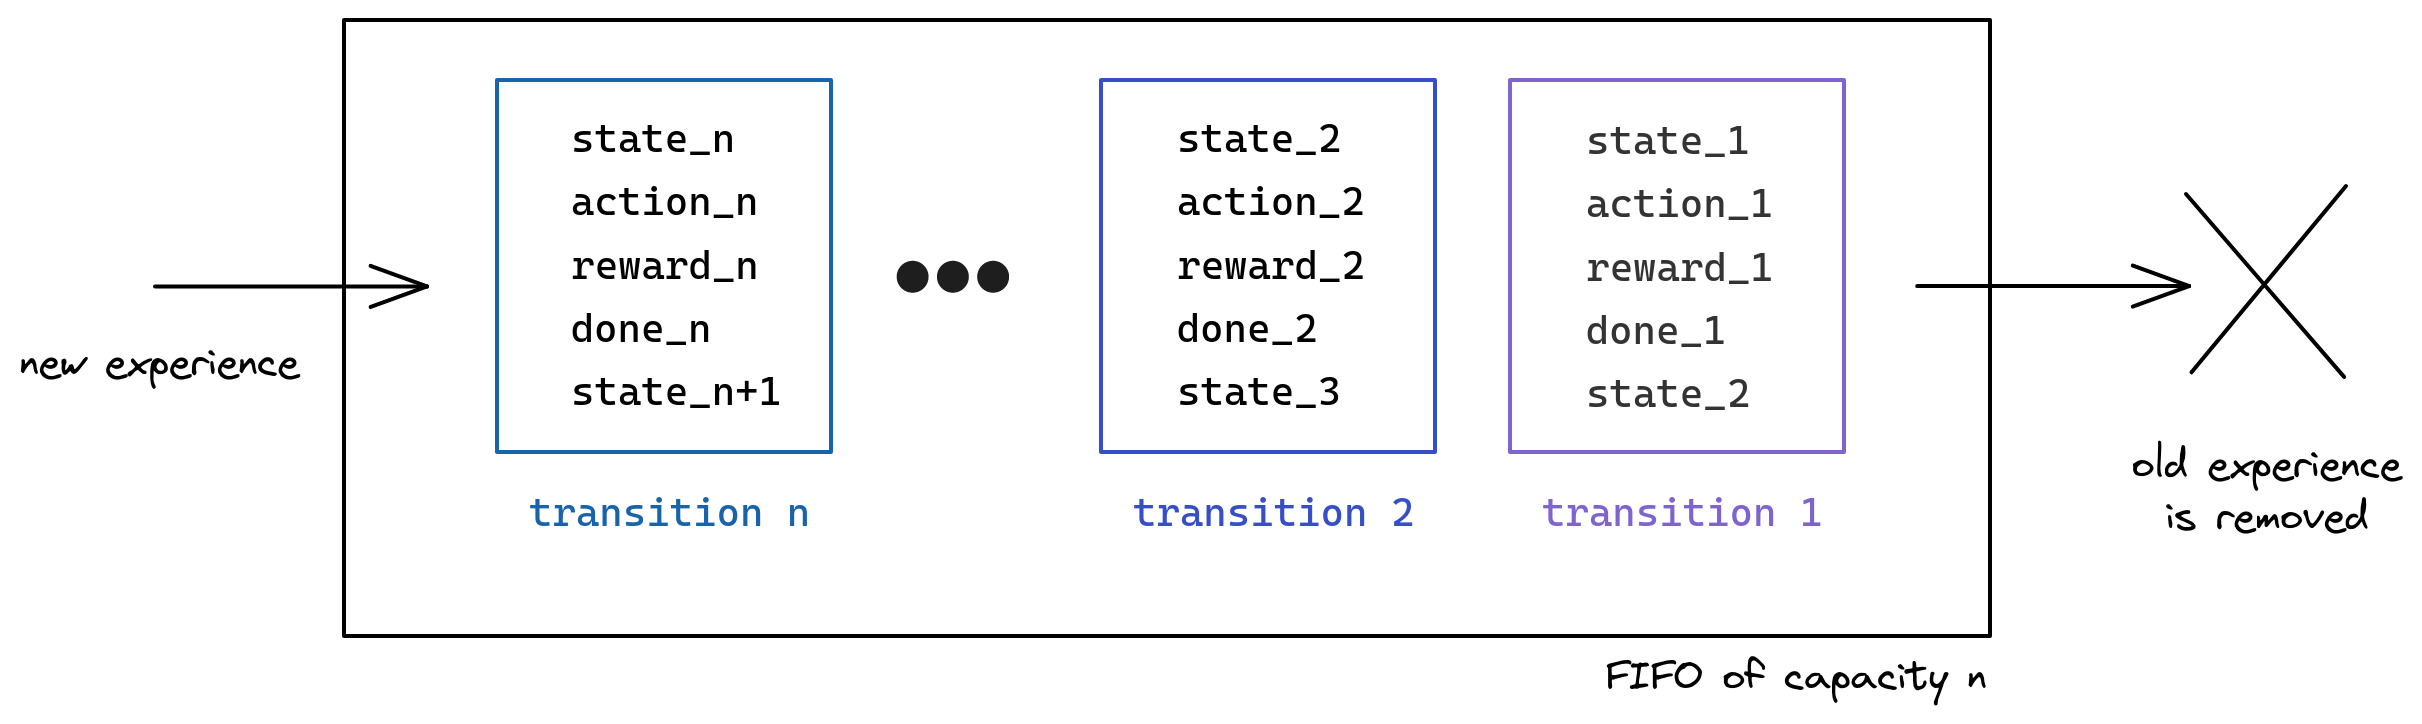
</div>

To update the Q-Network, DQN samples mini-batches from the replay buffer (vs the whole dataset for FQI).

Each mini-batch can be represented using this structure:

```python
@dataclass
class ReplayBufferSamples:
    """
    A dataclass containing transitions from the replay buffer.
    """

    observations: np.ndarray  # same as states in the theory
    next_observations: np.ndarray
    actions: np.ndarray
    rewards: np.ndarray
    terminated: np.ndarray
```

<div>
    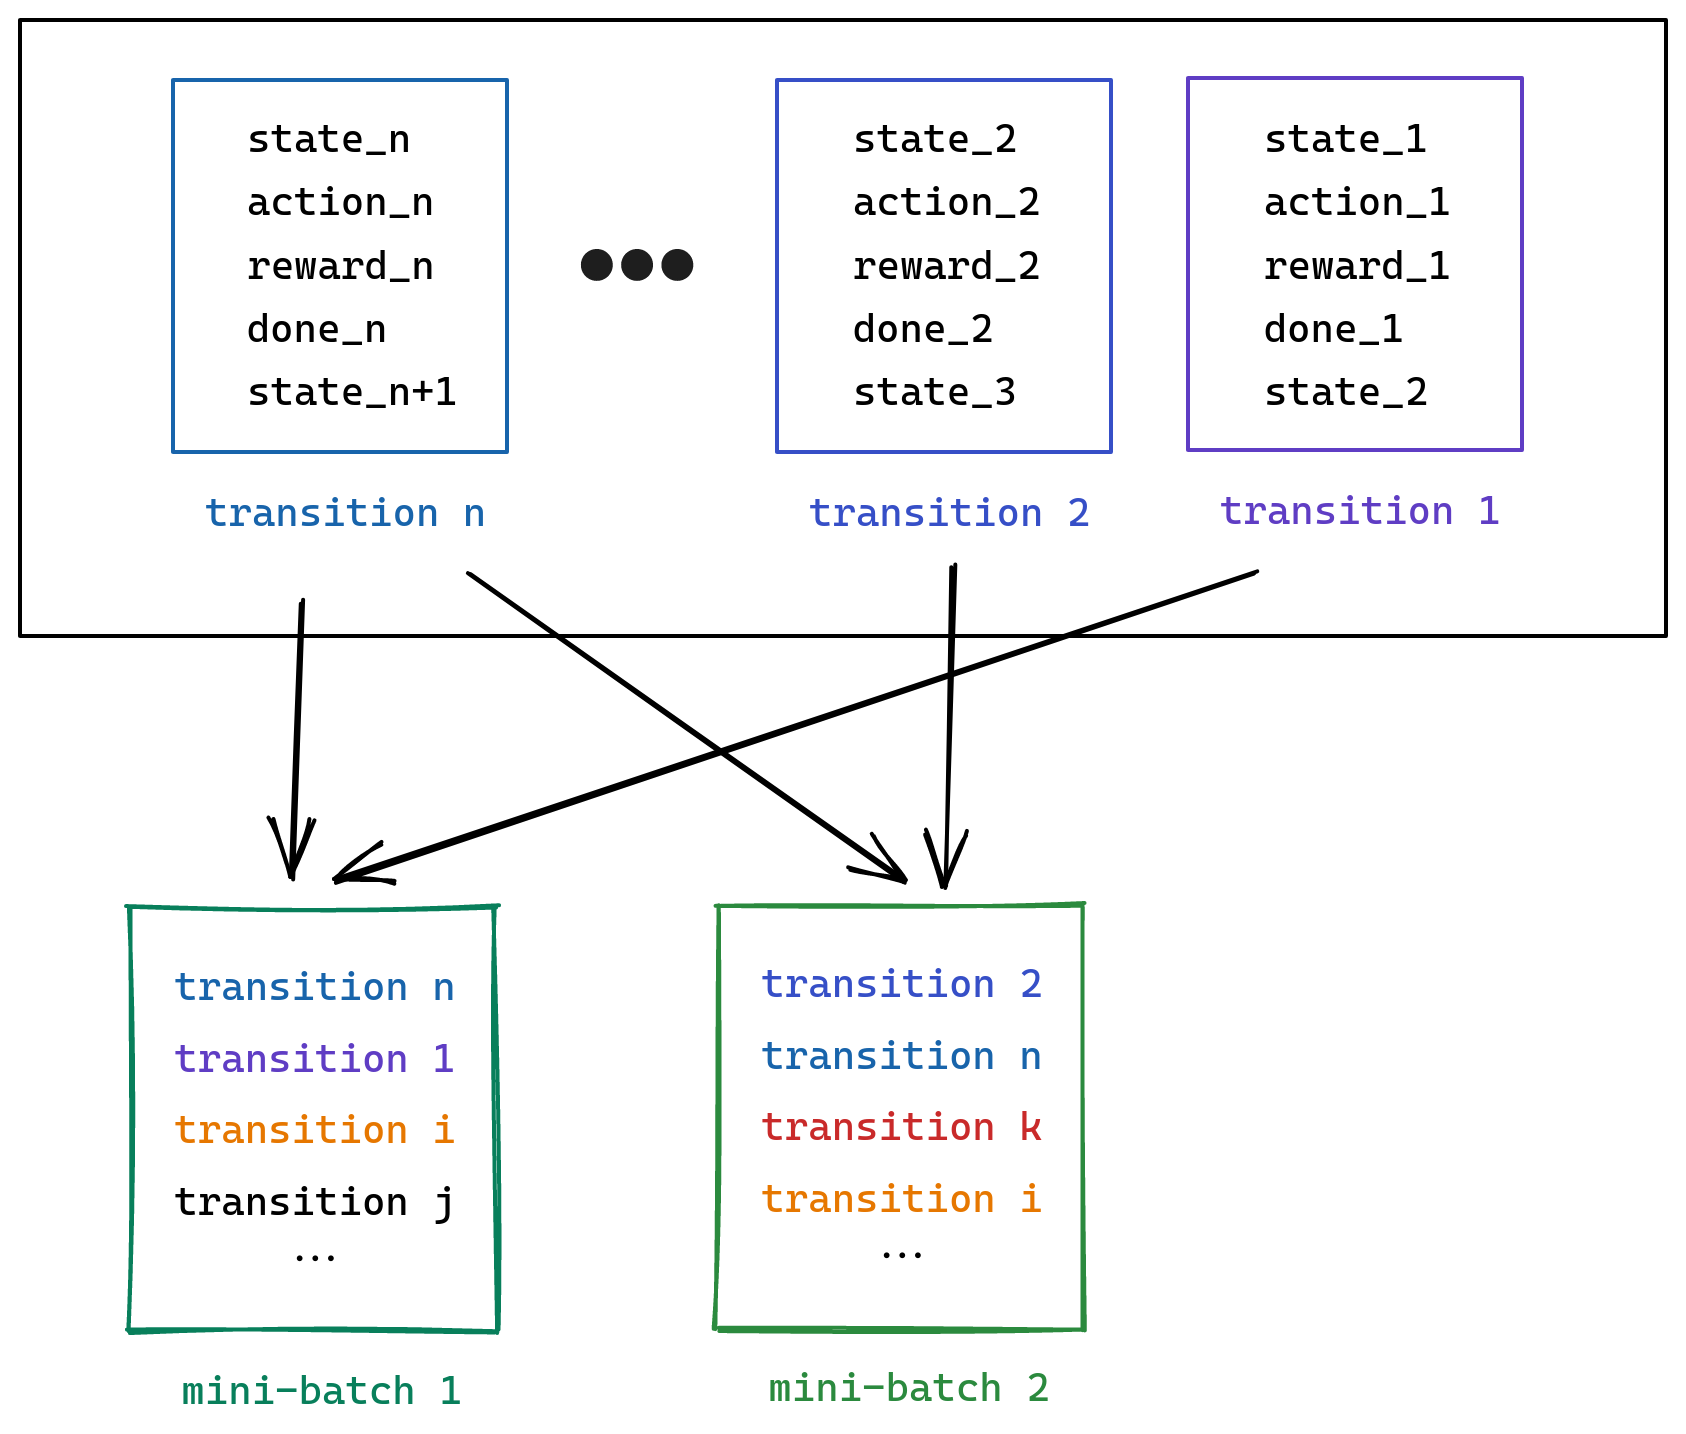
</div>


In [ ]:
from typing import Optional

import numpy as np
import torch as th
from gymnasium import spaces

from dqn_tutorial.dqn.replay_buffer import ReplayBufferSamples

### Exercise (10 minutes): write the replay buffer

In [ ]:
class ReplayBuffer:
    """
    A simple replay buffer class to store and sample transitions.

    :param buffer_size: Max number of transitions to store
    :param observation_space: Observation space of the env,
        contains information about the observation type and shape.
    :param action_space: Action space of the env,
        contains information about the number of actions.
    """

    def __init__(
        self,
        buffer_size: int,
        observation_space: spaces.Box,
        action_space: spaces.Discrete,
    ) -> None:
        # Current position in the ring buffer
        self.current_idx = 0
        self.buffer_size = buffer_size
        # Boolean flag to know when the buffer has reached its maximal capacity
        self.is_full = False

        self.observation_space = observation_space
        self.action_space = action_space
        # Create the different buffers
        self.observations = np.zeros((buffer_size, *observation_space.shape), dtype=observation_space.dtype)
        self.next_observations = np.zeros((buffer_size, *observation_space.shape), dtype=observation_space.dtype)
        # The action is an integer
        action_dim = 1
        self.actions = np.zeros((buffer_size, action_dim), dtype=action_space.dtype)

        ### YOUR CODE HERE
        
        # TODO: create the buffers (numpy arrays) for the rewards (dtype=np.float32)
        # and the terminated signals (dtype=bool)
        self.rewards = np.zeros((buffer_size,), dtype=np.float32)
        self.terminated = np.zeros((buffer_size,), dtype=bool)
        
        ### END OF YOUR CODE

    def store_transition(
        self,
        obs: np.ndarray,
        next_obs: np.ndarray,
        action: int,
        reward: float,
        terminated: bool,
    ) -> None:
        """
        Store one transition in the buffer.

        :param obs: Current observation
        :param next_obs: Next observation
        :param action: Action taken for the current observation
        :param reward: Reward received after taking the action
        :param terminated: Whether it is the end of an episode or not
            (discarding episode truncation like timeout)
        """
        ### YOUR CODE HERE

        # TODO:
        # 1. Update the different buffers defined in the __init__
        # 2. Update the pointer (`self.current_idx`), careful
        # the pointer need to be set to zero when reaching the end of the ring buffer

        # Update the buffers to store the new transition
        self.observations[self.current_idx] = obs
        self.next_observations[self.current_idx] = next_obs
        self.actions[self.current_idx] = action
        self.rewards[self.current_idx] = reward
        self.terminated[self.current_idx] = terminated

        # Update the pointer
        self.current_idx += 1
        # If the buffer is full, we start from zero again, this is a ring buffer
        # you also need to set the flag `is_full` to True (so we know the buffer has reached its max capacity)
        if self.current_idx == self.buffer_size:
            self.is_full = True
            self.current_idx = 0

        ### END OF YOUR CODE

    def sample(self, batch_size: int) -> ReplayBufferSamples:
        """
        Sample with replacement `batch_size` transitions from the buffer.

        :param batch_size: How many transitions to sample.
        :return: Samples from the replay buffer
        """
        ### YOUR CODE HERE

        # TODO:
        # 1. Retrieve the upper bound (max index that can be sampled)
        #  it corresponds to `self.buffer_size` when the ring buffer is full (we can samples all indices)
        # 2. Sample `batch_size` indices with replacement from the buffer
        # (in the range [0, upper_bound[ ), numpy has a method `np.random.randint` for that ;)
        upper_bound = self.buffer_size if self.is_full else self.current_idx
        batch_indices = np.random.randint(0, upper_bound, size=batch_size)

        ### END OF YOUR CODE

        return ReplayBufferSamples(
            self.observations[batch_indices],
            self.next_observations[batch_indices],
            self.actions[batch_indices],
            self.rewards[batch_indices],
            self.terminated[batch_indices],
        )

testing the replay buffer, without reaching max capacity:

In [ ]:
import gymnasium as gym

env = gym.make("CartPole-v1")

buffer_size = 1000
buffer = ReplayBuffer(buffer_size, env.observation_space, env.action_space)
obs, _ = env.reset()
# Fill the buffer
for _ in range(500):
    action = int(env.action_space.sample())
    next_obs, reward, terminated, truncated, _ = env.step(action)
    # Store new transition in the replay buffer
    buffer.store_transition(obs, next_obs, action, float(reward), terminated)
    # Update current observation
    obs = next_obs

    done = terminated or truncated
    if done:
        obs, _ = env.reset()

assert not buffer.is_full
assert buffer.current_idx == 500
samples = buffer.sample(batch_size=10)
assert len(samples.observations) == 10
assert samples.actions.shape == (10, 1)

Testing the replay buffer when reaching max capacity:

In [ ]:
# Fill the buffer completely
for _ in range(1000):
    action = int(env.action_space.sample())
    next_obs, reward, terminated, truncated, _ = env.step(action)
    buffer.store_transition(obs, next_obs, action, float(reward), terminated)
    # Update current observation
    obs = next_obs

    done = terminated or truncated
    if done:
        obs, _ = env.reset()

assert buffer.is_full
# We did a full loop
assert buffer.current_idx == 500
# Check sampling with replacement
# we should be able to sample more transitions
# than the capacity of the ring buffer
samples = buffer.sample(batch_size=1001)
assert len(samples.observations) == 1001
assert samples.actions.shape == (1001, 1)

### 2. Q-Network

<div>
    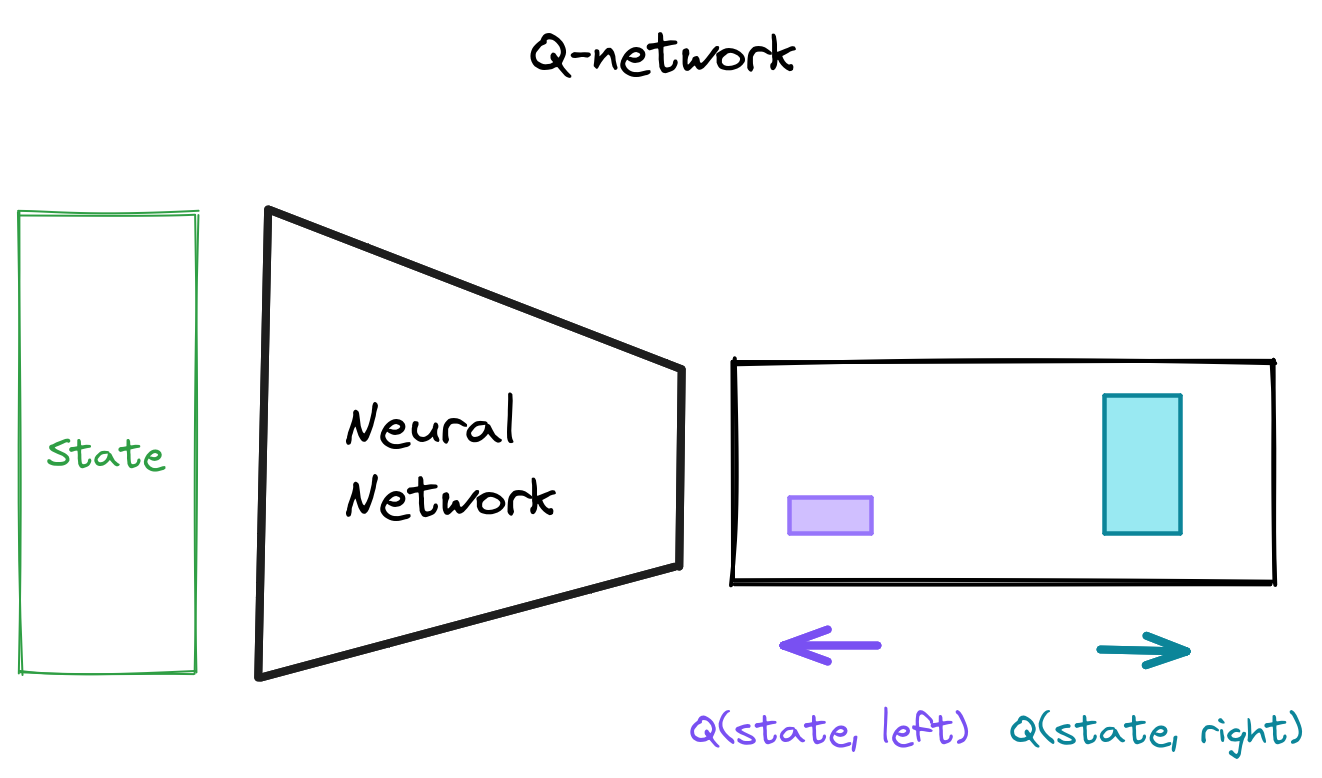
</div>

Similiar to FQI, the Q-Network estimates $Q_\pi(s_t, a_t)$, however, instead of taking the action as input, it outputs q-values for all possible actions as output.

### Exercise (7 minutes): write the Q-Network using PyTorch

In [ ]:
from typing import Type

import torch as th
import torch.nn as nn
from gymnasium import spaces


class QNetwork(nn.Module):
    """
    A Q-Network for the DQN algorithm
    to estimate the q-value for a given observation.

    :param observation_space: Observation space of the env,
        contains information about the observation type and shape.
    :param action_space: Action space of the env,
        contains information about the number of actions.
    :param n_hidden_units: Number of units for each hidden layer.
    :param activation_fn: Activation function (ReLU by default)
    """

    def __init__(
        self,
        observation_space: spaces.Box,
        action_space: spaces.Discrete,
        n_hidden_units: int = 64,
        activation_fn: Type[nn.Module] = nn.ReLU,
    ) -> None:
        super().__init__()
        # Assume 1d space
        obs_dim = observation_space.shape[0]

        ### YOUR CODE HERE
        # TODO:
        # 1. Retrieve the number of discrete actions,
        # that will be the number of ouputs of the q-network
        # 2. Create the q-network, it will be a two layers fully-connected
        # neural network which take the state (observation) as input
        # and outputs the q-values for all possible actions

        # Retrieve the number of discrete actions (using attribute `n` from `action_space`)
        n_actions = int(action_space.n)

        # Create the q network: a 2 fully connected hidden layers with `n_hidden_units` each
        # with `activation_fn` for the activation function after each hidden layer.
        # You should use `nn.Sequential` (combine several layers to create a network)
        # `nn.Linear` (fully connected layer) from PyTorch.
        self.q_net = nn.Sequential(
            nn.Linear(obs_dim, n_hidden_units),
            activation_fn(),
            nn.Linear(n_hidden_units, n_hidden_units),
            activation_fn(),
            nn.Linear(n_hidden_units, n_actions),
        )

        ### END OF YOUR CODE

    def forward(self, observations: th.Tensor) -> th.Tensor:
        """
        :param observations: A batch of observation (batch_size, obs_dim)
        :return: The Q-values for the given observations
            for all the action (batch_size, n_actions)
        """
        return self.q_net(observations)

To test your Q-Network:

In [ ]:
env = gym.make("CartPole-v1")
q_net = QNetwork(env.observation_space, env.action_space)

print(q_net)

obs, _ = env.reset()

with th.no_grad():
    # Create the input to the Q-Network
    obs_tensor = th.as_tensor(obs[np.newaxis, ...])
    q_values = q_net(obs_tensor)

    assert q_values.shape == (1, 2)

    best_action = q_values.argmax().item()

    assert isinstance(best_action, int)

### 3. Epsilon-greedy data collection

### Exercise (10 minutes): write the epsilon-greedy action selection strategy

<div>
    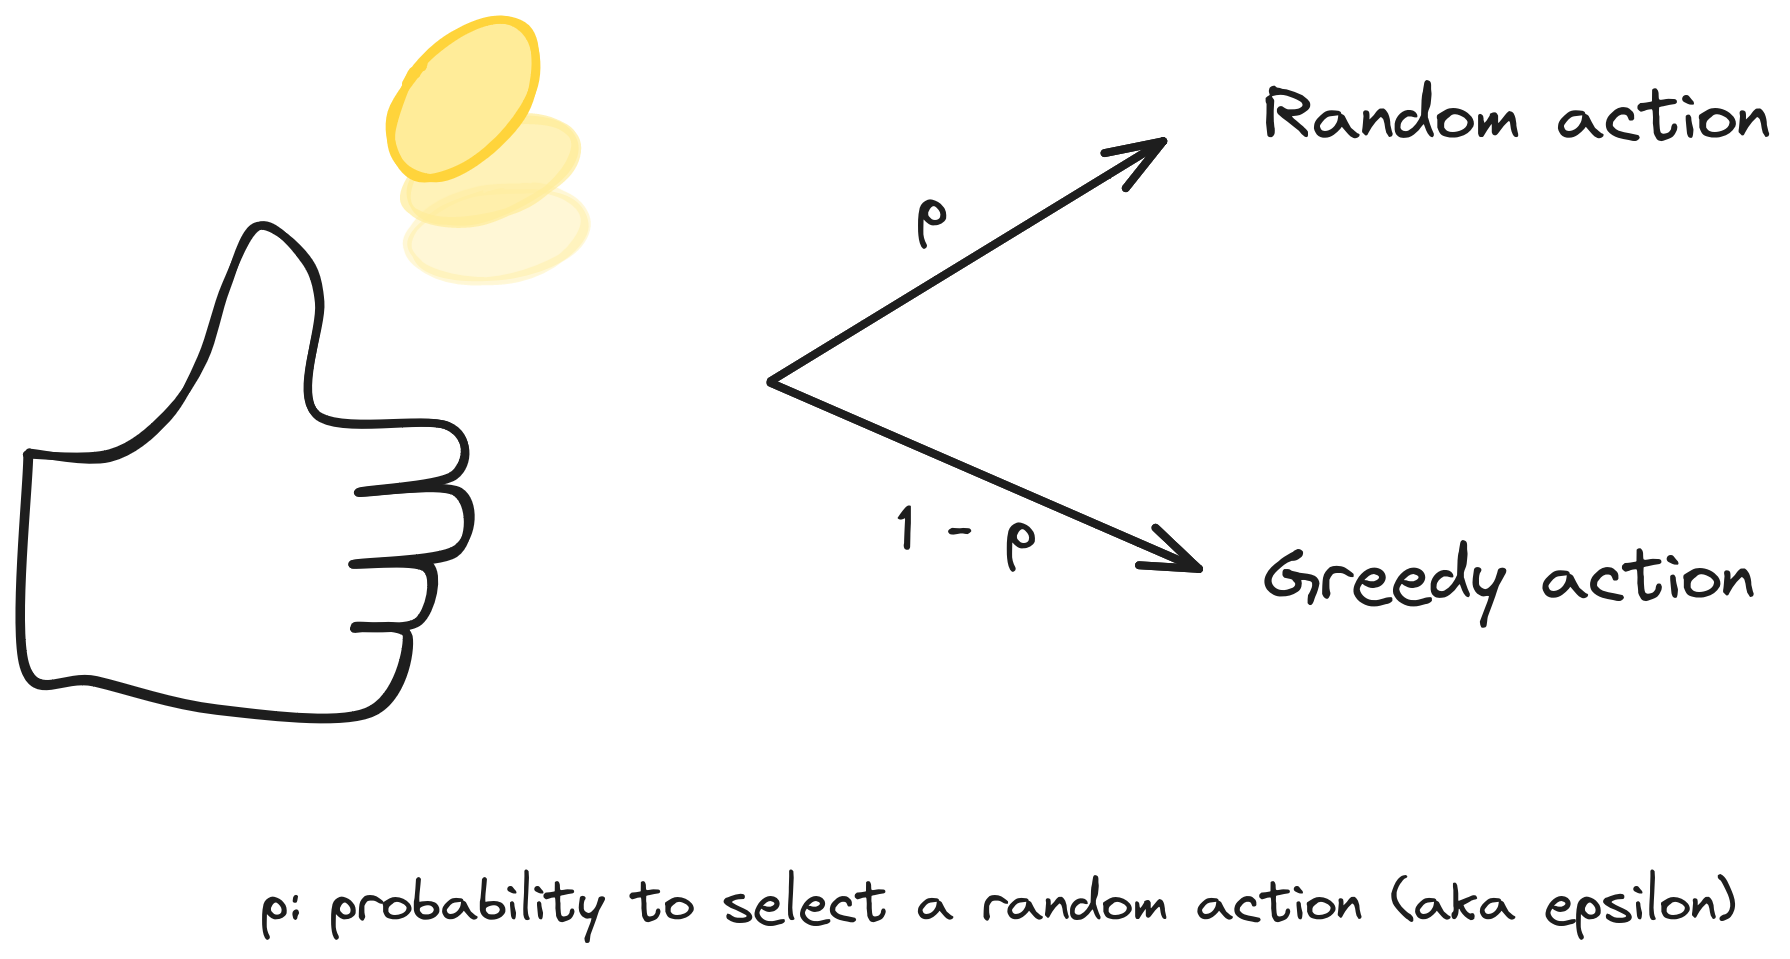
</div>

In [ ]:
def epsilon_greedy_action_selection(
    q_net: QNetwork,
    observation: np.ndarray,
    exploration_rate: float,
    action_space: spaces.Discrete,
    device: str = "cpu",
) -> int:
    """
    Select an action according to an espilon-greedy policy:
    with a probability of epsilon (`exploration_rate`),
    sample a random action, otherwise follow the best known action
    according to the q-value.

    :param observation: A single observation.
    :param q_net: Q-network for estimating the q value
    :param exploration_rate: Current rate of exploration (in [0, 1], 0 means no exploration),
        probability to select a random action,
        this is "epsilon".
    :param action_space: Action space of the env,
        contains information about the number of actions.
    :param device: PyTorch device
    :return: An action selected according to the epsilon-greedy policy.
    """
    ### YOUR CODE HERE
    # TODO:
    # 1. Toss a biased coin (you can use `np.random.rand()`)
    # to decide if the agent should take a random action or not
    # (with probability p=`exploration_rate`)
    # 2. Either take a random action (sample the action space)
    # or follow the greedy policy (take the action with the highest q-value)

    if np.random.rand() < exploration_rate:
        # Random action
        action = int(action_space.sample())
    else:
        # Greedy action
        # We do not need to compute the gradient, so we use `with th.no_grad():`
        with th.no_grad():
            # Convert the input to PyTorch tensor and add a batch dimension (obs_dim,) -> (1, obs_dim)
            # you can use `th.as_tensor` and numpy `[np.newaxis, ...]`
            obs_tensor = th.as_tensor(observation[np.newaxis, ...], device=device)
            # Compute q values for all actions
            q_values = q_net(obs_tensor)
            # Greedy policy: select action with the highest q value
            # you can use PyTorch `.argmax()` for that
            action = q_values.argmax().item()

    ### END OF YOUR CODE

    return action

### Exercise (7 minutes): Collect one transition and store it in the replay buffer

In [ ]:
def collect_one_step(
    env: gym.Env,
    q_net: QNetwork,
    replay_buffer: ReplayBuffer,
    obs: np.ndarray,
    exploration_rate: float = 0.1,
    verbose: int = 0,
) -> np.ndarray:
    """
    Collect one transition and fill the replay buffer following an epsilon greedy policy.

    :param env: The environment object.
    :param q_net: Q-network for estimating the q value
    :param replay_buffer: Replay buffer to store the new transitions.
    :param obs: The current observation.
    :param exploration_rate: Current rate of exploration (in [0, 1], 0 means no exploration),
        probability to select a random action,
        this is "epsilon".
    :param verbose: The verbosity level (1 to print some info).
    :return: The last observation (important when collecting data multiple times).
    """
    ### YOUR CODE HERE

    # Select an action following an epsilon-greedy policy
    # you should use `epsilon_greedy_action_selection()`
    action = epsilon_greedy_action_selection(q_net, obs, exploration_rate, env.action_space)
    # Step in the env
    next_obs, reward, terminated, truncated, info = env.step(action)
    # Store the transition in the replay buffer
    replay_buffer.store_transition(obs, next_obs, action, float(reward), terminated)
    # Update current observation
    obs = next_obs

    ### END OF YOUR CODE

    if "episode" in info and verbose >= 1:
        print(f"Episode return={float(info['episode']['r']):.2f} length={int(info['episode']['l'])}")

    done = terminated or truncated
    if done:
        # Don't forget to reset the env at the end of an episode
        obs, _ = env.reset()
    return obs

Let's test the data collection:

In [ ]:
env = gym.make("CartPole-v1")
q_net = QNetwork(env.observation_space, env.action_space)
buffer = ReplayBuffer(2000, env.observation_space, env.action_space)

obs, _ = env.reset()
for _ in range(1000):
    obs = collect_one_step(env, q_net, buffer, obs, exploration_rate=0.1)
    
# Check current buffer position
assert buffer.current_idx == 1000

# Collect more data
for _ in range(1000):
    obs = collect_one_step(env, q_net, buffer, obs, exploration_rate=0.1)
    
# Buffer is full
assert buffer.current_idx == 0
assert buffer.is_full

### Bonus: Exploration Schedule

<div>
    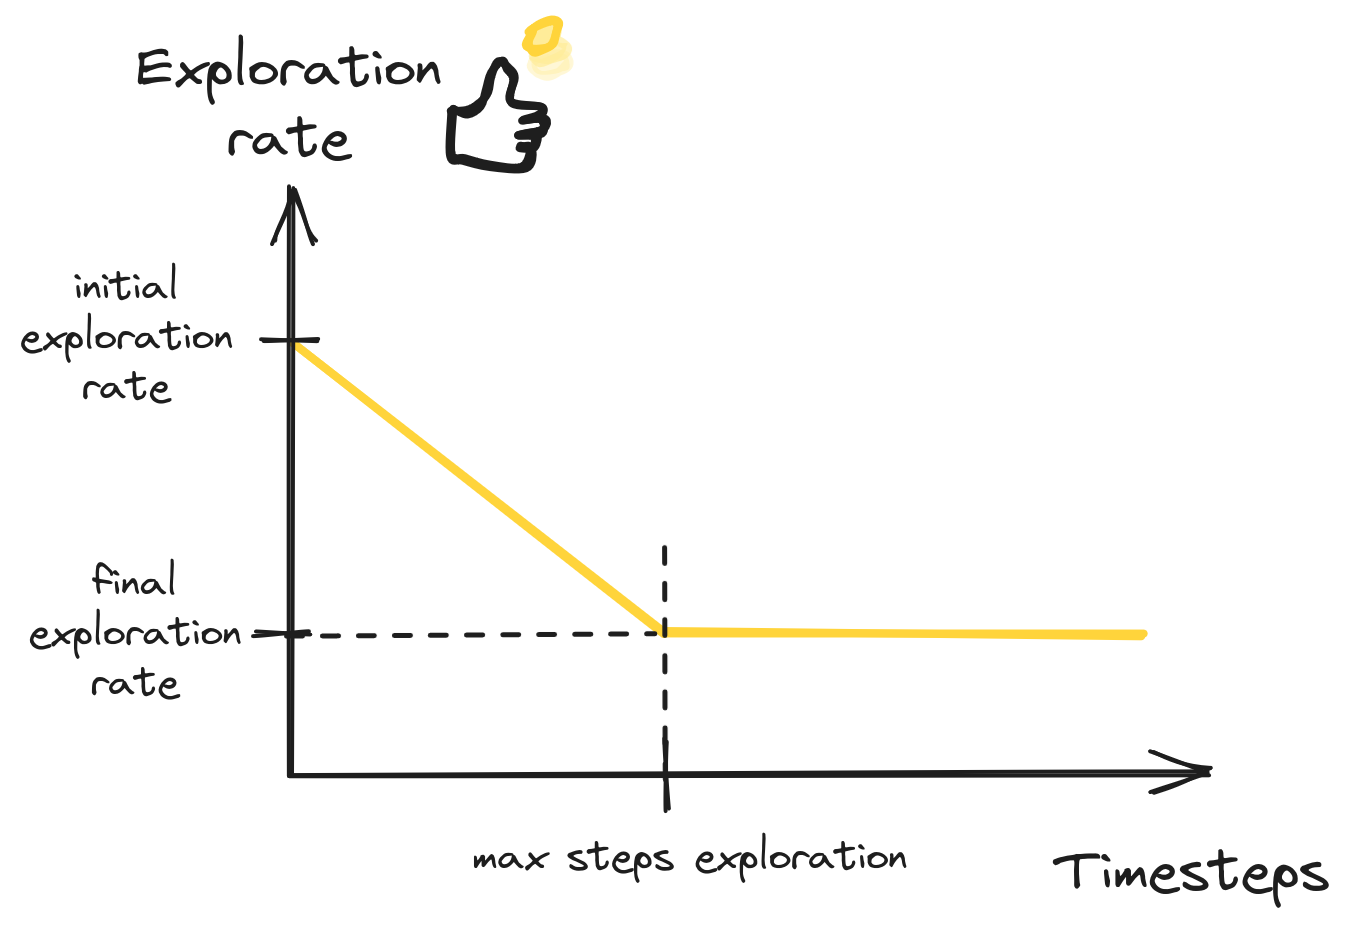
</div>


In [ ]:
def linear_schedule(initial_value: float, final_value: float, current_step: int, max_steps: int) -> float:
    """
    Linear schedule for the exploration rate (epsilon).
    Note: we clip the value so the schedule is constant after reaching the final value
    at `max_steps`.

    :param initial_value: Initial value of the schedule.
    :param final_value: Final value of the schedule.
    :param current_step: Current step of the schedule.
    :param max_steps: Maximum number of steps of the schedule.
    :return: The current value of the schedule.
    """
    ### YOUR CODE HERE
    
    # Compute current progress (in [0, 1], 0 being the start)
    progress = current_step / max_steps
    # Clip the progress so the schedule is constant after reaching the final value
    progress = min(progress, 1.0)
    current_value = initial_value + progress * (final_value - initial_value)

    ### END OF YOUR CODE
    
    return current_value

In [ ]:
# Linear schedule
exploration_initial_eps = 1.0
exploration_final_eps = 0.01
exploration_rate = exploration_initial_eps
n_steps = 100
for step in range(n_steps + 1):
    exploration_rate = linear_schedule(exploration_initial_eps, exploration_final_eps, step, n_steps)
    if step == 0:
        assert exploration_rate == exploration_initial_eps

    obs = collect_one_step(env, q_net, buffer, obs, exploration_rate=exploration_rate)

assert np.allclose(exploration_rate, exploration_final_eps)

### 4. DQN Update rule (no target network)
<div>
    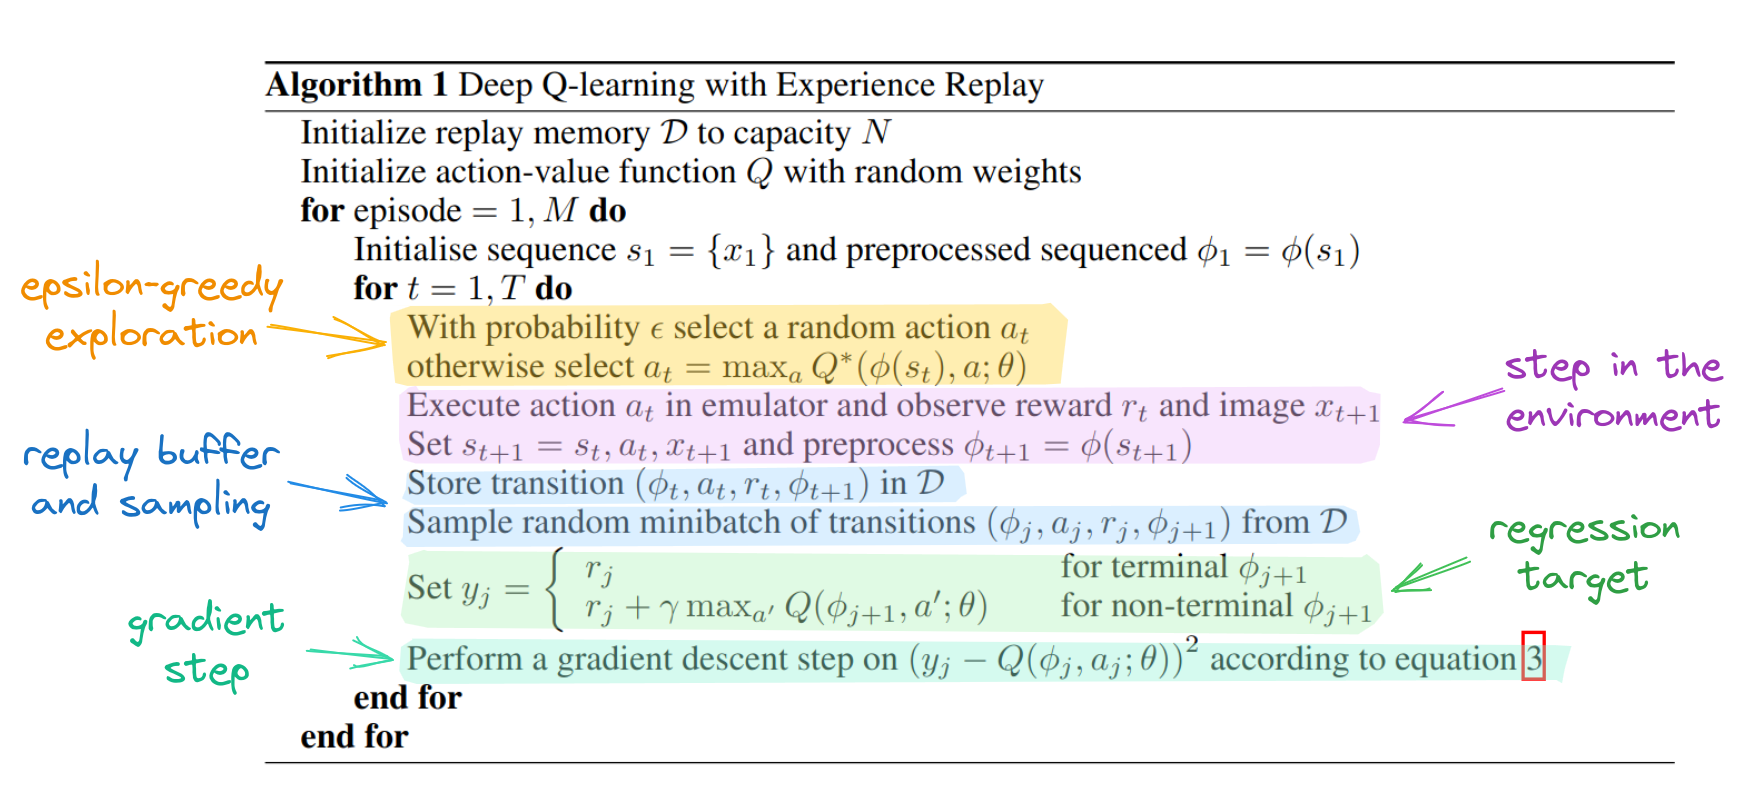
</div>


### Exercise (20 minutes): write DQN update

In [ ]:
def dqn_update_no_target(
    q_net: QNetwork,
    optimizer: th.optim.Optimizer,
    replay_buffer: ReplayBuffer,
    batch_size: int,
    gamma: float,
) -> None:
    """
    Perform one gradient step on the Q-network
    using the data from the replay buffer.
    Note: this is the same as dqn_update in dqn.py, but without the target network.

    :param q_net: The Q-network to update
    :param optimizer: The optimizer to use
    :param replay_buffer: The replay buffer containing the transitions
    :param batch_size: The minibatch size, how many transitions to sample
    :param gamma: The discount factor
    """
    ### YOUR CODE HERE

    # Sample the replay buffer and convert them to PyTorch tensors
    # using `.to_torch()` method
    replay_data = replay_buffer.sample(batch_size).to_torch()

    # We should not compute gradient with respect to the target
    with th.no_grad():
        # Compute the Q-values for the next observations (batch_size, n_actions)
        next_q_values = q_net(replay_data.next_observations)
        # Follow greedy policy: use the one with the highest value
        # (batch_size,)
        next_q_values, _ = next_q_values.max(dim=1)
        # If the episode is terminated, set the target to the reward
        # (same as FQI, you can use `th.logical_not` to mask the next q values)
        should_bootstrap = th.logical_not(replay_data.terminated)
        # 1-step TD target
        td_target = replay_data.rewards + gamma * next_q_values * should_bootstrap

    # Get current Q-values estimates for the replay_data (batch_size, n_actions)
    q_values = q_net(replay_data.observations)
    # Select the Q-values corresponding to the actions that were selected
    # during data collection,
    # you should use `th.gather()`
    current_q_values = th.gather(q_values, dim=1, index=replay_data.actions)
    # Reshape from (batch_size, 1) to (batch_size,) to avoid broadcast error
    current_q_values = current_q_values.squeeze(dim=1)

    # Check for any shape/broadcast error
    # Current q-values must have the same shape as the TD target
    assert current_q_values.shape == (batch_size,), f"{current_q_values.shape} != {(batch_size,)}"
    assert current_q_values.shape == td_target.shape, f"{current_q_values.shape} != {td_target.shape}"

    # Compute the Mean Squared Error (MSE) loss
    # Optionally, one can use a Huber loss instead of the MSE loss
    loss = ((current_q_values - td_target) ** 2).mean()

    ### END OF YOUR CODE

    # Reset gradients
    optimizer.zero_grad()
    # Compute the gradients
    loss.backward()
    # Update the parameters of the q-network
    optimizer.step()

In [ ]:
from dqn_tutorial.dqn import linear_schedule
from dqn_tutorial.dqn.dqn_no_target import evaluate_policy

Let's put everything together:

<div>
    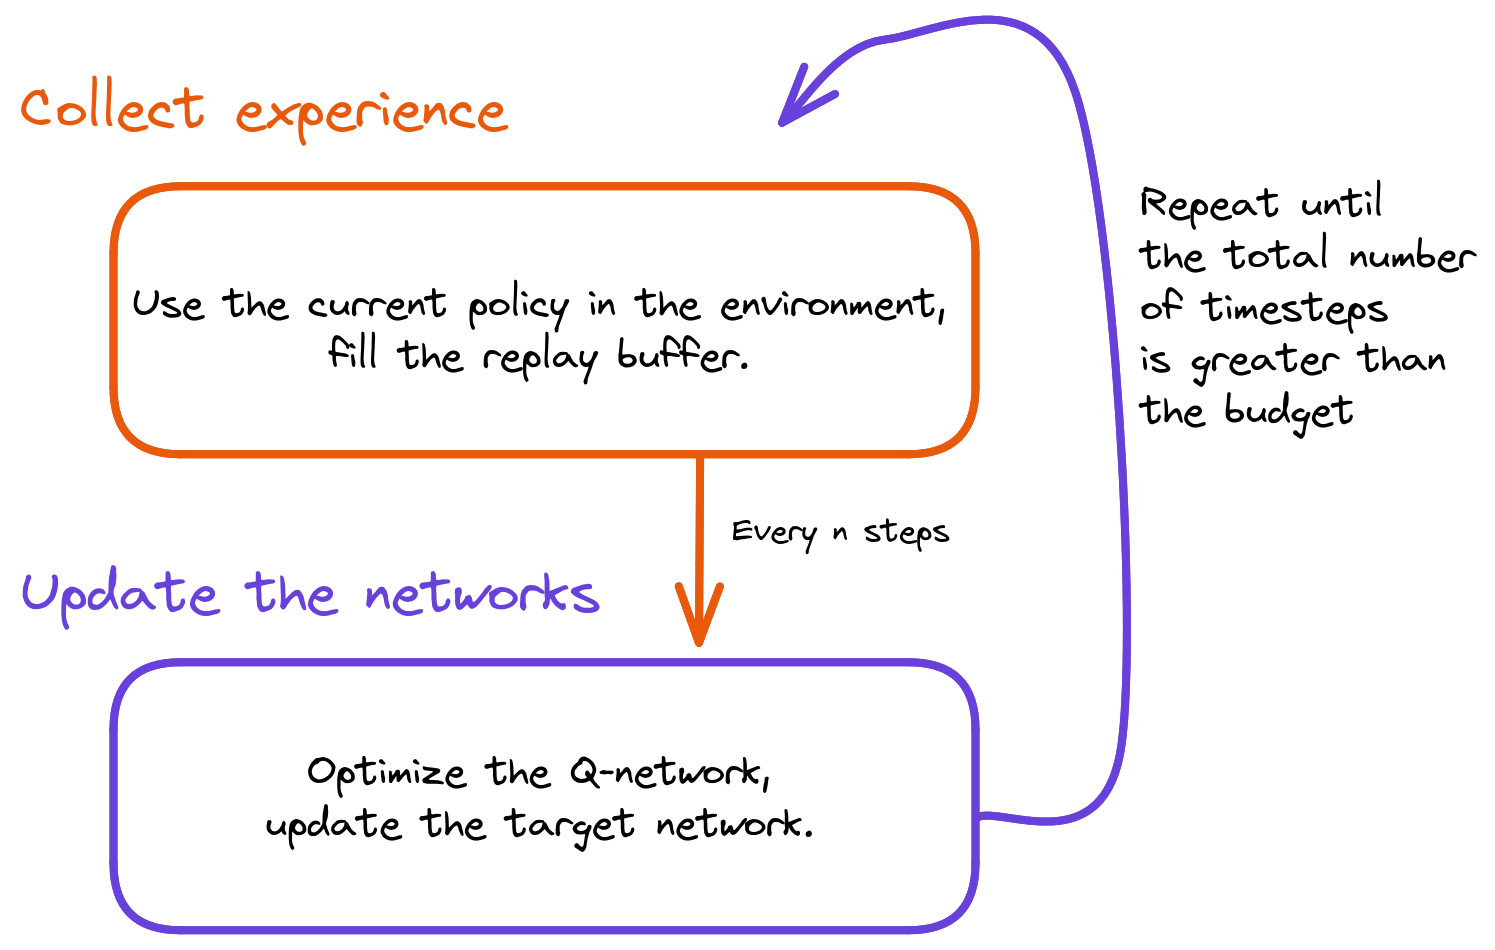
</div>

In [ ]:
def run_dqn_no_target(
    env_id: str = "CartPole-v1",
    replay_buffer_size: int = 50_000,
    # Exploration schedule
    # (for the epsilon-greedy data collection)
    exploration_initial_eps: float = 1.0,
    exploration_final_eps: float = 0.01,
    n_timesteps: int = 20_000,
    update_interval: int = 2,
    learning_rate: float = 3e-4,
    batch_size: int = 64,
    gamma: float = 0.99,
    n_eval_episodes: int = 10,
    evaluation_interval: int = 1000,
    eval_exploration_rate: float = 0.0,
    seed: int = 2023,
    # device: Union[th.device, str] = "cpu",
    eval_render_mode: Optional[str] = None,  # "human", "rgb_array", None
) -> QNetwork:
    """
    Run Deep Q-Learning (DQN) on a given environment.
    (without target network)

    :param env_id: Name of the environment
    :param replay_buffer_size: Max capacity of the replay buffer
    :param exploration_initial_eps: The initial exploration rate
    :param exploration_final_eps: The final exploration rate
    :param n_timesteps: Number of timesteps in total
    :param update_interval: How often to update the Q-network
        (every update_interval steps)
    :param learning_rate: The learning rate to use for the optimizer
    :param batch_size: The minibatch size
    :param gamma: The discount factor
    :param n_eval_episodes: The number of episodes to evaluate the policy on
    :param evaluation_interval: How often to evaluate the policy
    :param eval_exploration_rate: The exploration rate to use during evaluation
    :param seed: Random seed for the pseudo random generator
    :param eval_render_mode: The render mode to use for evaluation
    """
    # Set seed for reproducibility
    # Seed Numpy as PyTorch pseudo random generators
    # Seed Numpy RNG
    np.random.seed(seed)
    # seed the RNG for all devices (both CPU and CUDA)
    th.manual_seed(seed)

    # Create the environment
    env = gym.make(env_id)
    assert isinstance(env.observation_space, spaces.Box)
    assert isinstance(env.action_space, spaces.Discrete)
    env.action_space.seed(seed)

    # Create the evaluation environment
    eval_env = gym.make(env_id, render_mode=eval_render_mode)
    eval_env.reset(seed=seed)
    eval_env.action_space.seed(seed)

    # Create the q-network
    q_net = QNetwork(env.observation_space, env.action_space)
    # Create the optimizer
    optimizer = th.optim.Adam(q_net.parameters(), lr=learning_rate)

    # Create the Replay buffer
    replay_buffer = ReplayBuffer(replay_buffer_size, env.observation_space, env.action_space)
    # Reset the env
    obs, _ = env.reset(seed=seed)
    for current_step in range(1, n_timesteps + 1):
        # Update the current exploration schedule (update the value of epsilon)
        exploration_rate = linear_schedule(
            exploration_initial_eps,
            exploration_final_eps,
            current_step,
            n_timesteps,
        )
        # Do one step in the environment following an epsilon-greedy policy
        # and store the transition in the replay buffer
        obs = collect_one_step(env, q_net, replay_buffer, obs, exploration_rate=exploration_rate)

        if (current_step % update_interval) == 0:
            # Do one gradient step
            dqn_update_no_target(q_net, optimizer, replay_buffer, batch_size, gamma=gamma)

        if (current_step % evaluation_interval) == 0:
            print()
            print(f"Evaluation at step {current_step}:")
            # Evaluate the current greedy policy (deterministic policy)
            evaluate_policy(eval_env, q_net, n_eval_episodes, eval_exploration_rate=eval_exploration_rate)
    return q_net

In [ ]:
run_dqn_no_target("CartPole-v1")

### [Bonus] 5. DQN Target Network


<div>
    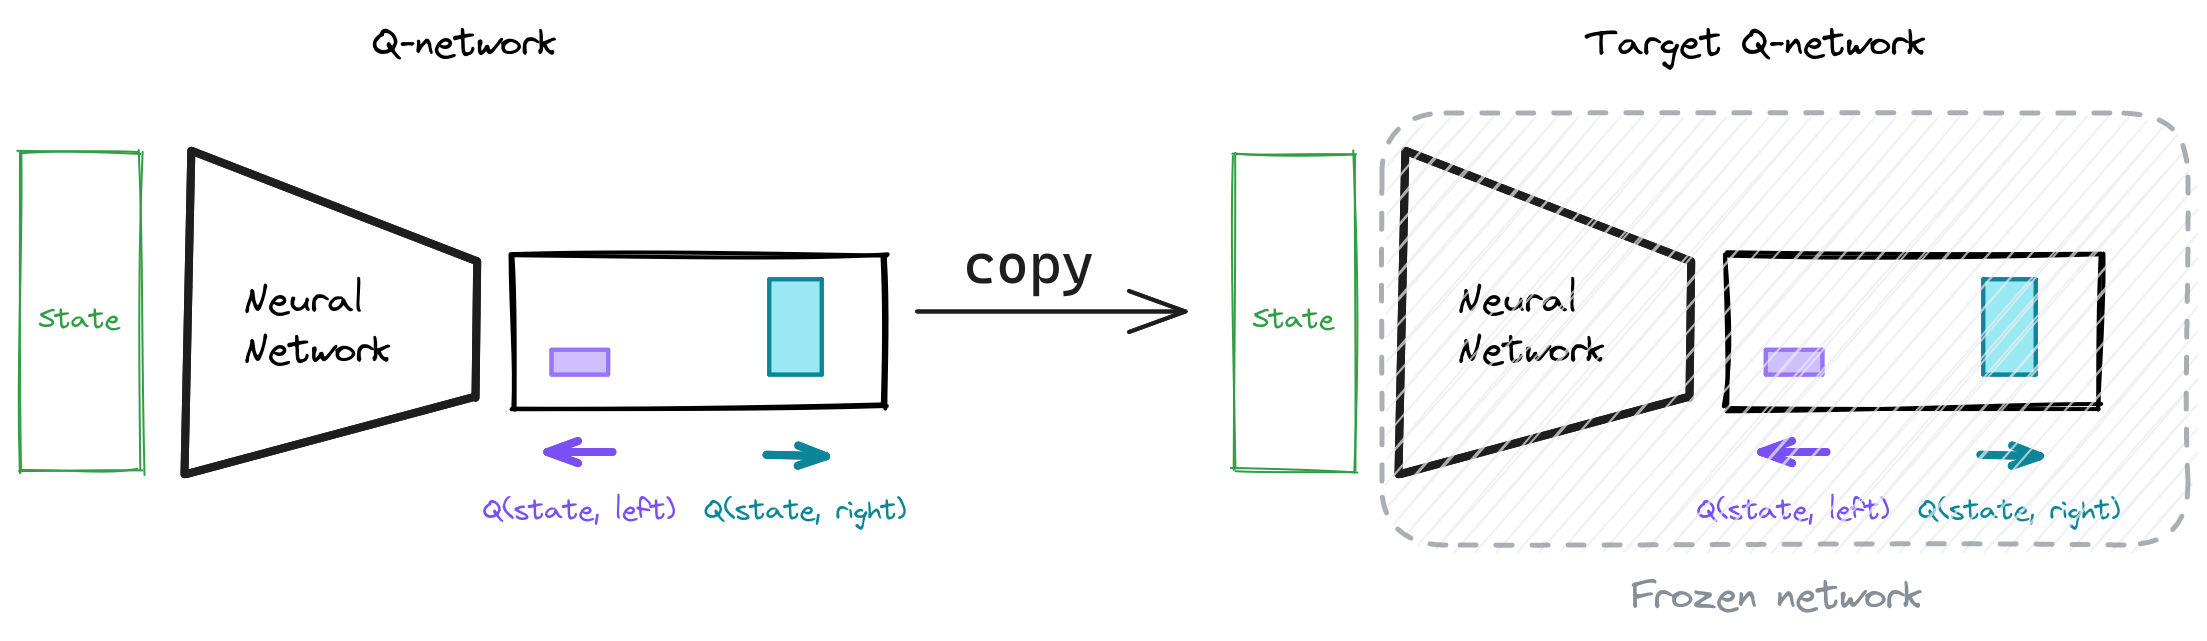
</div>

### Exercise (5 minutes): write the DQN update with target network

In [ ]:
def dqn_update(
    q_net: QNetwork,
    q_target_net: QNetwork,
    optimizer: th.optim.Optimizer,
    replay_buffer: ReplayBuffer,
    batch_size: int,
    gamma: float,
) -> None:
    """
    Perform one gradient step on the Q-network
    using the data from the replay buffer.

    :param q_net: The Q-network to update
    :param q_target_net: The target Q-network, to compute the td-target.
    :param optimizer: The optimizer to use
    :param replay_buffer: The replay buffer containing the transitions
    :param batch_size: The minibatch size, how many transitions to sample
    :param gamma: The discount factor
    """

    # Sample the replay buffer and convert them to PyTorch tensors
    replay_data = replay_buffer.sample(batch_size).to_torch()

    with th.no_grad():
        ### YOUR CODE HERE
        # TODO: use the target q-network instead of the online q-network
        # to compute the next values
        
        # Compute the Q-values for the next observations (batch_size, n_actions)
        # using the target network
        next_q_values = q_target_net(replay_data.next_observations)
        # Follow greedy policy: use the one with the highest value
        # (batch_size,)
        next_q_values, _ = next_q_values.max(dim=1)
        # If the episode is terminated, set the target to the reward
        should_bootstrap = th.logical_not(replay_data.terminated)
        # 1-step TD target
        td_target = replay_data.rewards + gamma * next_q_values * should_bootstrap

        ### END OF YOUR CODE

    # Get current Q-values estimates for the replay_data (batch_size, n_actions)
    q_values = q_net(replay_data.observations)
    # Select the Q-values corresponding to the actions that were selected
    # during data collection
    current_q_values = th.gather(q_values, dim=1, index=replay_data.actions)
    # Reshape from (batch_size, 1) to (batch_size,) to avoid broadcast error
    current_q_values = current_q_values.squeeze(dim=1)

    # Check for any shape/broadcast error
    # Current q-values must have the same shape as the TD target
    assert current_q_values.shape == (batch_size,), f"{current_q_values.shape} != {(batch_size,)}"
    assert current_q_values.shape == td_target.shape, f"{current_q_values.shape} != {td_target.shape}"

    # Compute the Mean Squared Error (MSE) loss
    # Optionally, one can use a Huber loss instead of the MSE loss
    loss = ((current_q_values - td_target) ** 2).mean()
    # Huber loss
    # loss = th.nn.functional.smooth_l1_loss(current_q_values, td_target)

    # Reset gradients
    optimizer.zero_grad()
    # Compute the gradients
    loss.backward()
    # Update the parameters of the q-network
    optimizer.step()

In [ ]:
def run_dqn(
    env_id: str = "CartPole-v1",
    replay_buffer_size: int = 50_000,
    # How often do we copy the parameters from the Q-network to the target network
    target_network_update_interval: int = 1000,
    # Warmup phase
    learning_starts: int = 100,
    # Exploration schedule
    # (for the epsilon-greedy data collection)
    exploration_initial_eps: float = 1.0,
    exploration_final_eps: float = 0.01,
    exploration_fraction: float = 0.1,
    n_timesteps: int = 20_000,
    update_interval: int = 2,
    learning_rate: float = 3e-4,
    batch_size: int = 64,
    gamma: float = 0.99,
    n_hidden_units: int = 64,
    n_eval_episodes: int = 10,
    evaluation_interval: int = 1000,
    eval_exploration_rate: float = 0.0,
    seed: int = 2023,
    # device: Union[th.device, str] = "cpu",
    eval_render_mode: Optional[str] = None,  # "human", "rgb_array", None
) -> QNetwork:
    """
    Run Deep Q-Learning (DQN) on a given environment.
    (with a target network)

    :param env_id: Name of the environment
    :param replay_buffer_size: Max capacity of the replay buffer
    :param target_network_update_interval: How often do we copy the parameters
         to the target network
    :param learning_starts: Warmup phase to fill the replay buffer
        before starting the optimization.
    :param exploration_initial_eps: The initial exploration rate
    :param exploration_final_eps: The final exploration rate
    :param exploration_fraction: The fraction of the number of steps
        during which the exploration rate is annealed from
        initial_eps to final_eps.
        After this many steps, the exploration rate remains constant.
    :param n_timesteps: Number of timesteps in total
    :param update_interval: How often to update the Q-network
        (every update_interval steps)
    :param learning_rate: The learning rate to use for the optimizer
    :param batch_size: The minibatch size
    :param gamma: The discount factor
    :param n_hidden_units: Number of units for each hidden layer
        of the Q-Network.
    :param n_eval_episodes: The number of episodes to evaluate the policy on
    :param evaluation_interval: How often to evaluate the policy
    :param eval_exploration_rate: The exploration rate to use during evaluation
    :param seed: Random seed for the pseudo random generator
    :param eval_render_mode: The render mode to use for evaluation
    """
    # Set seed for reproducibility
    # Seed Numpy as PyTorch pseudo random generators
    # Seed Numpy RNG
    np.random.seed(seed)
    # seed the RNG for all devices (both CPU and CUDA)
    th.manual_seed(seed)

    # Create the environment
    env = gym.make(env_id)
    # For highway env
    env = gym.wrappers.FlattenObservation(env)
    env = gym.wrappers.RecordEpisodeStatistics(env)
    assert isinstance(env.observation_space, spaces.Box)
    assert isinstance(env.action_space, spaces.Discrete)
    env.action_space.seed(seed)

    # Create the evaluation environment
    eval_env = gym.make(env_id, render_mode=eval_render_mode)
    eval_env = gym.wrappers.FlattenObservation(eval_env)
    eval_env.reset(seed=seed)
    eval_env.action_space.seed(seed)

    # Create the q-network
    q_net = QNetwork(env.observation_space, env.action_space, n_hidden_units=n_hidden_units)
    # Create the target network
    q_target_net = QNetwork(env.observation_space, env.action_space, n_hidden_units=n_hidden_units)
    # Copy the parameters of the q-network to the target network
    q_target_net.load_state_dict(q_net.state_dict())

    # For flappy bird
    if env.observation_space.dtype == np.float64:
        q_net.double()
        q_target_net.double()

    # Create the optimizer, we only optimize the parameters of the q-network
    optimizer = th.optim.Adam(q_net.parameters(), lr=learning_rate)

    # Create the Replay buffer
    replay_buffer = ReplayBuffer(replay_buffer_size, env.observation_space, env.action_space)
    # Reset the env
    obs, _ = env.reset(seed=seed)
    for current_step in range(1, n_timesteps + 1):
        # Update the current exploration schedule (update the value of epsilon)
        exploration_rate = linear_schedule(
            exploration_initial_eps,
            exploration_final_eps,
            current_step,
            int(exploration_fraction * n_timesteps),
        )
        # Do one step in the environment following an epsilon-greedy policy
        # and store the transition in the replay buffer
        obs = collect_one_step(
            env,
            q_net,
            replay_buffer,
            obs,
            exploration_rate=exploration_rate,
            verbose=0,
        )

        # Update the target network
        # by copying the parameters from the Q-network every target_network_update_interval steps
        if (current_step % target_network_update_interval) == 0:
            q_target_net.load_state_dict(q_net.state_dict())

        # Update the Q-network every update_interval steps
        # after learning_starts steps have passed (warmup phase)
        if (current_step % update_interval) == 0 and current_step > learning_starts:
            # Do one gradient step
            dqn_update(q_net, q_target_net, optimizer, replay_buffer, batch_size, gamma=gamma)

        if (current_step % evaluation_interval) == 0:
            print()
            print(f"Evaluation at step {current_step}:")
            print(f"exploration_rate={exploration_rate:.2f}")
            # Evaluate the current greedy policy (deterministic policy)
            evaluate_policy(eval_env, q_net, n_eval_episodes, eval_exploration_rate=eval_exploration_rate)
    return q_net

In [ ]:
# Tuned hyperparameters from the RL Zoo3 of the Stable Baselines3 library
# https://github.com/DLR-RM/rl-baselines3-zoo/blob/master/hyperparams/dqn.yml
run_dqn(
    env_id="CartPole-v1",
    replay_buffer_size=100_000,
    # Note: you can remove the target network
    # by setting target_network_update_interval=1
    target_network_update_interval=10,
    learning_starts=1000,
    exploration_initial_eps=1.0,
    exploration_final_eps=0.04,
    exploration_fraction=0.1,
    n_timesteps=80_000,
    update_interval=2,
    learning_rate=1e-3,
    batch_size=64,
    gamma=0.99,
    n_eval_episodes=10,
    evaluation_interval=5000,
    # No exploration during evaluation
    # (deteministic policy)
    eval_exploration_rate=0.0,
    seed=2022,
)

On flappy bird:

<div>
    <img src="https://raw.githubusercontent.com/markub3327/flappy-bird-gymnasium/main/imgs/dqn.gif" width="300"/>
</div>


In [ ]:
!pip install "flappy-bird-gymnasium @ git+https://github.com/araffin/flappy-bird-gymnasium@patch-1"

In [ ]:
import flappy_bird_gymnasium  # noqa: F401

In [ ]:
run_dqn(
    env_id="FlappyBird-v0",
    replay_buffer_size=100_000,
    # Note: you can remove the target network
    # by setting target_network_update_interval=1
    target_network_update_interval=250,
    learning_starts=10_000,
    exploration_initial_eps=1.0,
    exploration_final_eps=0.03,
    exploration_fraction=0.1,
    n_timesteps=500_000,
    update_interval=4,
    learning_rate=1e-3,
    batch_size=128,
    gamma=0.98,
    n_eval_episodes=2,
    evaluation_interval=50000,
    n_hidden_units=256,
    # No exploration during evaluation
    # (deteministic policy)
    eval_exploration_rate=0.0,
    seed=2023,
    eval_render_mode=None,
)

### Going further

- analyse the learned q-values
- explore different value for the target update, use soft update instead of hard-copy
- play with different environments
- implement a CNN to play flappybird/pong from pixels (need to stack frames)
- implement DQN extensions (double Q-learning, prioritized experience replay, ...)